# Chapter 72 (Meta Learning)

### This code generates figure 4 and 8 in Chapter 72: Meta Learning (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. torch
5. torchvision
6. pandas

The other ones are not necessary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import pandas as pd
import scipy
from functions import *

## Example 72.1 (Similarities among handwritten digits)

We illustrate the operation of the Siamese network for 5-way one-shot learning by considering the MNIST dataset for handwritten digits. Recall that this dataset consists of 60,000 labeled training samples and 10,000 labeled testing samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784$-long feature vector, $h_n$. Each pixel in the image, and therefore each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range $0$--$9$ depending on which digit the image corresponds to. The earlier Fig. 65.12 shows randomly selected images from the training dataset.
 
 
We pre-process the images (or the corresponding feature vectors $\{h_n\}$) by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the mean feature vectors for the training set and for the test set. We center the scaled feature vectors around these means in both sets. The earlier Fig. 52.7 shows randomly selected images for the digits $\{0,1\}$ before and after processing. 
 
We repeat the iterations of algorithm (72.41) for $6,000,000$ times. During each iteration, we select a random batch of data points following the construction explained right after (72.17) using $K=5$ and $Q=10$. Figure 72.4 shows several instances of  support + query samples for illustration purposes. Each  feedforward neural network consists of four layers: one input layer, one output layer, and two hidden layers. The size of the input layer is $n_1=784$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_4=10$ (since there are $Q=10$ classes). The size of hidden layers is set to $n_2=n_3=512$ neurons. We assume all nodes employ sigmoidal activation functions. We train  the Siamese network using a regularized cross-entropy criterion with parameters

$
\mu=0.001,\;\;\;\rho=0.0001,\;\;\;\;N=6,000,000 
$

We select the initial parameters for the network at random according to the construction explained in Section 65.5 using the Gaussian distributions (65.88)--(65.89).

In [120]:
class MNISTSiameseDataset(Dataset):
    def __init__(self, data_csv: str, K: int):
        data = torch.tensor(pd.read_csv(data_csv, delimiter=",").values)
        self.len = data.shape[0]
        self.data_per_class = {c: data[data[:, 0] == c] for c in range(10)}
        self.K = K
        
    def __len__(self):
        return self.len

    def sample_from_class(self, class_):
        class_samples = self.data_per_class[class_]
        sample = class_samples[np.random.randint(class_samples.shape[0])]
        return sample

    def __getitem__(self, index):
        query_class = np.random.randint(10)
        classes_drop_query = np.delete(np.arange(10), query_class)
        support_classes = classes_drop_query[np.random.permutation(classes_drop_query.shape[0])[:self.K-1]]
        support_classes = np.append(support_classes, query_class)

        query_sample = self.sample_from_class(query_class)[1:].reshape(1, -1)/255 # drop the y value

        support_samples = torch.concat([self.sample_from_class(class_)[1:].reshape(1, -1)/255 for class_ in support_classes], axis=0)

        label = torch.tensor((support_classes == query_class)).float()

        return query_sample, support_samples, label, query_class, support_classes


Donwload de data files in: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv/

In [121]:
train_dataset = MNISTSiameseDataset("data/mnist_train.csv", 5)
test_dataset = MNISTSiameseDataset("data/mnist_test.csv", 10)

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_datalaoder = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [78]:
class DistanceLayer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_a, x_b):
        d = torch.abs(x_a-x_b)
        d_ = self.linear(d)
        y = self.sigmoid(d_)

        return y

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        feedforward = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Sigmoid()
        )

        self.netA = feedforward
        self.netB = feedforward

        self.distance_layer = DistanceLayer()

    def forward(self, x_a, x_b):
        y_a = self.netA(x_a)
        y_b = self.netB(x_b)

        y = self.distance_layer(y_a, y_b)

        return y

In [140]:
model = SiameseNetwork()
lr = 1e-4
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
runs = 6e4

In [141]:
iter_train_laoder = iter(train_dataloader)
iter_test_laoder = iter(test_datalaoder)
train_loss = []
test_loss = []
for r in range(int(runs)):
    model.train()
    optimizer.zero_grad()
    query_sample, support_samples, label, query_class, support_classes = next(iter(train_dataloader))
    label_hat = model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))

    loss_out = loss(label_hat.reshape(-1), label.reshape(-1))
    loss_out.backward()
    optimizer.step()
    train_loss.append(loss_out.item())

    if r % 100 == 0:
        model.eval()
        query_sample, support_samples, label, query_class, support_classes = next(iter(test_datalaoder))
        label_hat = model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))
        loss_out = loss(label_hat.reshape(-1), label.reshape(-1))
        test_loss.append(loss_out.item())

    if r % 1000 == 0:
        print(f"Run: {r}/{runs}. Training Error: {round(sum(train_loss)/len(train_loss), 3)}. Test Error: {round(sum(test_loss)/len(test_loss), 3)}.")
        train_loss = []
        test_loss = []


Run: 0/60000.0. Training Error: 0.643. Test Error: 0.625.
Run: 1000/60000.0. Training Error: 0.523. Test Error: 0.457.
Run: 2000/60000.0. Training Error: 0.443. Test Error: 0.37.
Run: 3000/60000.0. Training Error: 0.412. Test Error: 0.296.
Run: 4000/60000.0. Training Error: 0.386. Test Error: 0.299.
Run: 5000/60000.0. Training Error: 0.37. Test Error: 0.257.
Run: 6000/60000.0. Training Error: 0.364. Test Error: 0.246.
Run: 7000/60000.0. Training Error: 0.357. Test Error: 0.248.
Run: 8000/60000.0. Training Error: 0.35. Test Error: 0.272.
Run: 9000/60000.0. Training Error: 0.343. Test Error: 0.247.
Run: 10000/60000.0. Training Error: 0.334. Test Error: 0.259.
Run: 11000/60000.0. Training Error: 0.333. Test Error: 0.23.
Run: 12000/60000.0. Training Error: 0.326. Test Error: 0.264.
Run: 13000/60000.0. Training Error: 0.315. Test Error: 0.217.
Run: 14000/60000.0. Training Error: 0.321. Test Error: 0.257.
Run: 15000/60000.0. Training Error: 0.304. Test Error: 0.199.
Run: 16000/60000.0. Train

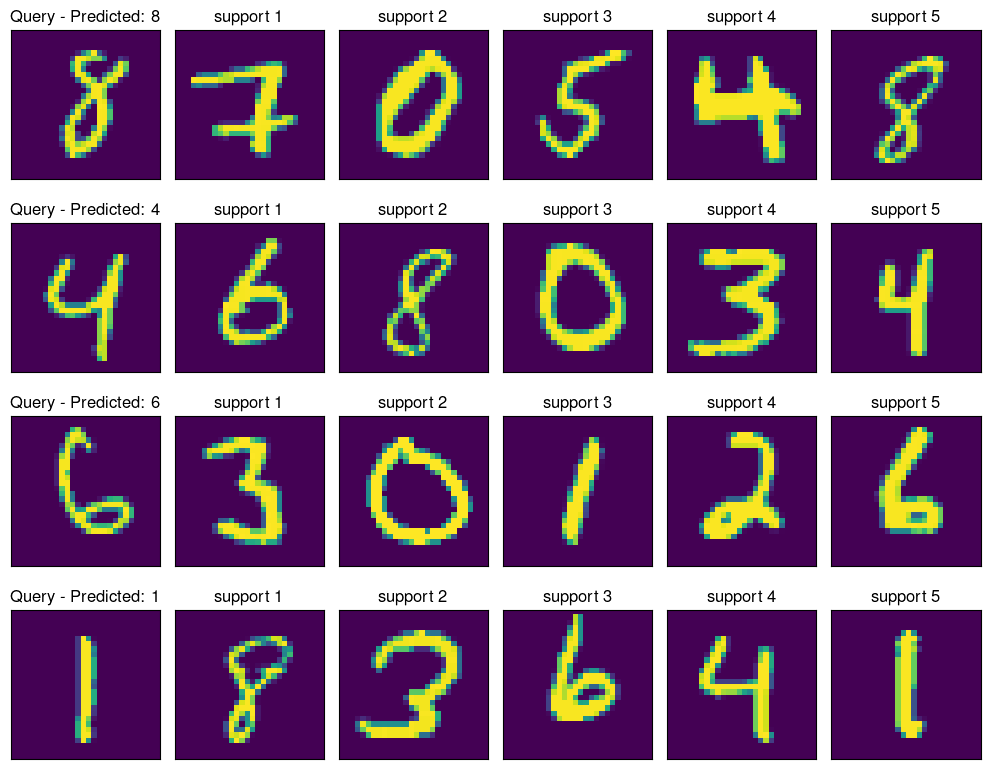

In [176]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 8
fig = plt.figure()

for r in range(4):
    query_sample, support_samples, label, query_class, support_classes = next(iter(train_dataloader))
    label_hat = model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))
    predicted_class = support_classes.squeeze()[torch.argmax(label_hat.squeeze()).item()].item()

    ax = fig.add_subplot(4, 6, r*6+1)
    ax.imshow(query_sample[0][0].reshape((28, 28)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Query - Predicted: {predicted_class}")

    for s in range(1, 6):
        ax = fig.add_subplot(4, 6, r*6+s+1)
        ax.imshow(support_samples[0][s-1].reshape((28, 28)))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"support {s}")

fig.tight_layout()

plt.savefig("figs/fig-4.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 72.4** The rows show several instances of support + query samples used for five-way one-shot learning in a Siamese network.

At the end of the  runs, we test the performance of the trained Siamese network  using $10,000$ randomly generated collections of support+query samples; each test involves five support samples and one query sample from one of the classes in the support set. The simulation led to $4.58\%$ error rate ($95.42\%$ accuracy rate).

In [182]:
model.eval()
predicted_labels = []
true_labels = []
for r in tqdm(range(10000)):
    query_sample, support_samples, label, query_class, support_classes = next(iter(test_datalaoder))
    label_hat = model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))
    predicted_class = support_classes.squeeze()[torch.argmax(label_hat.squeeze()).item()].item()

    predicted_labels.append(predicted_class)
    true_labels.append(query_class.item())
acc = ((np.array(predicted_labels) == np.array(true_labels)).sum() / len(true_labels))*100
print(f"Accuracy: {acc}")

100%|██████████| 10000/10000 [00:11<00:00, 836.78it/s]

Accuracy: 91.28


In [188]:
class RelationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        feedforward = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

        self.netA = feedforward
        self.netB = feedforward

        self.relation = nn.Sequential(
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x_a, x_b):
        y_a = self.netA(x_a)
        y_b = self.netB(x_b)
        
        y = torch.cat([y_b.expand(y_a.shape), y_a], dim=-1)

        y = self.relation(y)

        return y

In [191]:
relation_model = RelationNetwork()
lr = 1e-5
loss = nn.BCELoss()
relation_optimizer = torch.optim.Adam(relation_model.parameters(), lr=lr)
runs = 6e4

In [195]:
lr = 1e-6
relation_optimizer = torch.optim.Adam(relation_model.parameters(), lr=lr)
train_loss = []
test_loss = []
for r in range(int(runs)):
    relation_model.train()
    optimizer.zero_grad()
    query_sample, support_samples, label, query_class, support_classes = next(iter(train_dataloader))
    label_hat = relation_model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))

    loss_out = loss(label_hat.reshape(-1), label.reshape(-1))
    loss_out.backward()
    relation_optimizer.step()
    train_loss.append(loss_out.item())

    if r % 100 == 0:
        relation_model.eval()
        query_sample, support_samples, label, query_class, support_classes = next(iter(test_datalaoder))
        label_hat = relation_model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))
        loss_out = loss(label_hat.reshape(-1), label.reshape(-1))
        test_loss.append(loss_out.item())

    if r % 1000 == 0:
        print(f"Run: {r}/{runs}. Training Error: {round(sum(train_loss)/len(train_loss), 3)}. Test Error: {round(sum(test_loss)/len(test_loss), 3)}.")
        train_loss = []
        test_loss = []

Run: 0/60000.0. Training Error: 0.43. Test Error: 0.202.
Run: 1000/60000.0. Training Error: 0.21. Test Error: 0.164.
Run: 2000/60000.0. Training Error: 0.21. Test Error: 0.131.
Run: 3000/60000.0. Training Error: 0.218. Test Error: 0.136.
Run: 4000/60000.0. Training Error: 0.222. Test Error: 0.195.
Run: 5000/60000.0. Training Error: 0.22. Test Error: 0.22.
Run: 6000/60000.0. Training Error: 0.227. Test Error: 0.187.
Run: 7000/60000.0. Training Error: 0.212. Test Error: 0.155.
Run: 8000/60000.0. Training Error: 0.228. Test Error: 0.098.
Run: 9000/60000.0. Training Error: 0.207. Test Error: 0.12.
Run: 10000/60000.0. Training Error: 0.221. Test Error: 0.1.
Run: 11000/60000.0. Training Error: 0.212. Test Error: 0.126.
Run: 12000/60000.0. Training Error: 0.203. Test Error: 0.235.
Run: 13000/60000.0. Training Error: 0.232. Test Error: 0.143.
Run: 14000/60000.0. Training Error: 0.209. Test Error: 0.213.
Run: 15000/60000.0. Training Error: 0.209. Test Error: 0.123.
Run: 16000/60000.0. Training 

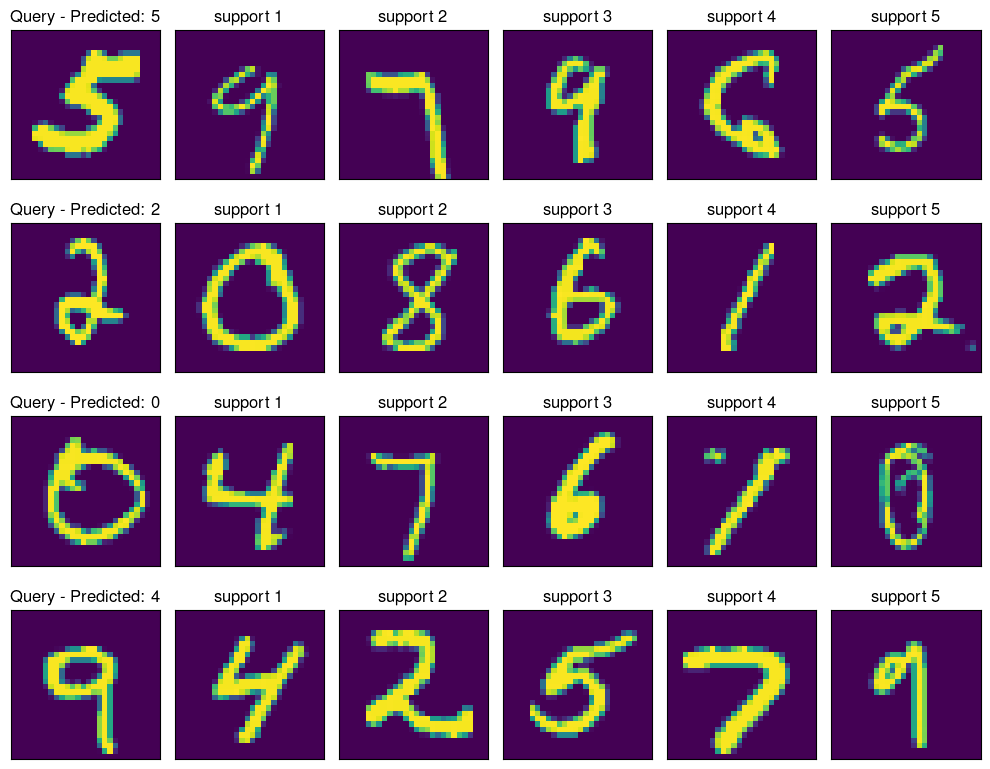

In [196]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 8
fig = plt.figure()

for r in range(4):
    query_sample, support_samples, label, query_class, support_classes = next(iter(train_dataloader))
    label_hat = relation_model(support_samples.squeeze(dim=0), query_sample.squeeze(dim=0))
    predicted_class = support_classes.squeeze()[torch.argmax(label_hat.squeeze()).item()].item()

    ax = fig.add_subplot(4, 6, r*6+1)
    ax.imshow(query_sample[0][0].reshape((28, 28)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Query - Predicted: {predicted_class}")

    for s in range(1, 6):
        ax = fig.add_subplot(4, 6, r*6+s+1)
        ax.imshow(support_samples[0][s-1].reshape((28, 28)))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"support {s}")

fig.tight_layout()

plt.savefig("figs/fig-4-extra.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Example 72.2 (Classification of handwritten digits)

We illustrate the operation of the MAML/FOMAML/Reptile constructions by considering the MNIST dataset for handwritten digits from Example 72.1. Now, however, we separate the MNIST images into four exploratory datasets. Dataset ${\cal D}_1$ contains the images corresponding to digits $\{1,2\}$, dataset ${\cal D}_2$ contains the images corresponding to digits $\{4,6\}$, dataset ${\cal D}_3$ contains the images corresponding to digits $\{0,7\}$, and dataset ${\cal D}_4$ contains the images corresponding to digits $\{5,8\}$. Observe that images for the digits $\{3,9\}$ are left out from these datasets since the target samples will be selected from these digits. During each iteration of the MAML algorithm (72.107) we select $N_e=50$ support samples at random and $N_{e}'=20$ query samples also at random for each dataset ${\cal D}_e$. We further select $N_{t}=4$ target samples: two of them correspond to the digit $3$ and the other two to the digit $9$. Figure 72.8 displays the four target samples along with randomly selected handwritten digits from the exploratory datasets $\{{\cal D}_e\}$ for illustration purposes.

In [2]:
def relu_function(z):
    K = max(z.shape)
    zprime = np.ones(K)
    for k in range(K):
        if z[k] < 0:
            zprime[k] = 0
        else:
            zprime[k] = z[k]
    return zprime

In [5]:
mnist_data = scipy.io.loadmat("data/mnist_normalized.mat")

In [50]:
features_train = mnist_data["train_features_norm"]
labels_train = mnist_data["train_norm_labels"]
features_test = mnist_data["test_features_norm"]
labels_test = mnist_data["test_norm_labels"]
number_of_classes = 10

K = 5
N_train = max(features_train.shape)
N_test = max(features_test.shape)

counter_train = np.array([(labels_train == c ).sum() for c in range(10)]).reshape((number_of_classes, 1))
counter_test = np.array([(labels_test == c ).sum() for c in range(10)]).reshape((number_of_classes, 1))

max_train_len = counter_train.max()
max_test_len = counter_test.max()

train_digits = np.zeros((number_of_classes, max_train_len, 1, 28*28))
test_digits = np.zeros((number_of_classes, max_test_len, 1, 28*28))

labels_train = labels_train.reshape(-1)
labels_test = labels_test.reshape(-1)

counter_train_list = [0]*number_of_classes
counter_test_list = [0]*number_of_classes

for n in range(N_train):
    c = int(labels_train[n])
    if c == 0:
        c = 10
    train_digits[c-1, counter_train_list[c-1]] = features_train[n].reshape(1, -1)
    counter_train_list[c-1] += 1

for n in range(N_test):
    c = int(labels_test[n])
    if c == 0:
        c = 10
    test_digits[c-1, counter_test_list[c-1]] = features_test[n].reshape(1, -1)
    counter_test_list[c-1] += 1

counter_train = np.array(counter_train_list).reshape(-1, 1)
counter_test = np.array(counter_test_list).reshape(-1, 1)



In [52]:


# user can run different algorithms by adjusting the flag "type" below:
type_ = 1 # 1 = MAML 2 = FOMAML 3 = REPTILE

mu = 0.001 # step-size for computing database models
beta = 0.001 # step-size for computing target model
rho = 0.0001 # l2-regularization

RUNS = 2000 # run this many iterations to find exploration/launch models
RUNS2 = 500 # run this many iterations to find target model

Ng = 4 # number of given target samples
NgTOTAL = 1000 # number of test target samples to be used for testing purposes
Nsupport = 50 # number of support samples per batch
Nquery = 20 # number of query samples per batch

L = 4 # total number of layers in each network
Qstar = 2 # size of output layer for original network (classifying between two digits).
M = 784 # feature size 
n1 = 784 # size of input layer, which is equal to M
n2 = 512 # number of nodes in hidden layer 2
n3 = 512  # number of nodes in hidden layer 3
n4 = Qstar # same as output layer
nL = Qstar # size of output layer, which is equal to the number of labels

target = [3, 9] # target classes that we want to classify for which (Wtg,thetatg) should be determined
database = [[1, 2], [4, 6], [10, 7], [5, 8]] # 4 databases
T = len(database) # number of databases 

# Initialization
Wcell = [[None]*L for _ in range(T)] # Wcell[t]: Weights for dataset t
ThetaCell = [[None]*L for _ in range(T)] # ThetaCell[t]: bias vector for dataset t

Wtarget = [] # MAML paramters
thetatarget = []
Wlaunch = [None]*(L-1)
thetalaunch = [None]*(L-1)

WtargetFOMAML = [] # FOMAML parameters
thetatargetFOMAML = []
WlaunchFOMAML = [None]*(L-1)
thetalaunchFOMAML = [None]*(L-1)

WtargetREPTILE = [] # REPTILE parameters
thetatargetREPTILE = []
WlaunchREPTILE = [None]*(L-1)
thetalaunchREPTILE = [None]*(L-1)

W1 = (1/np.sqrt(n1))*np.random.randn(n2, n1)
W2 = (1/np.sqrt(n2))*np.random.randn(n3, n2)
W3 = (1/np.sqrt(n3))*np.random.randn(n4, n3)

theta1 = np.random.randn(n2)
theta2 = np.random.randn(n3)
theta3 = np.random.randn(n4)

WCellstar = [W1, W2, W3] # a cell array containing the weight matrices of different dimensions
ThetaCellstar = [theta1, theta2, theta3] # a cell array for the thetas

WCellstarORIGINAL = WCellstar.copy()
ThetaCellstarORIGINAL = ThetaCellstar.copy()

Nt = np.zeros(T, dtype=np.int16) # number of samples for training per dataset
Ntprime = np.zeros(T, dtype=np.int16) # number of samples for testing per dataset

for t in range(T):
    Wcell[t][0] = (1/np.sqrt(n1))*np.random.randn(n2, n1)
    Wcell[t][1] = (1/np.sqrt(n2))*np.random.randn(n3, n2)
    Wcell[t][2] = (1/np.sqrt(n3))*np.random.randn(n4, n3)

    ThetaCell[t][0] = np.random.randn(n2)
    ThetaCell[t][1] = np.random.randn(n3)
    ThetaCell[t][2] = np.random.randn(n4)

    Nt[t] = int(Nsupport) # how many samples used for training from dataset t
    Ntprime[t] = int(Nquery) # how many samples used for testing from dataset t

Wcell_before = Wcell.copy()
ThetaCell_before = ThetaCell.copy()

yCell = [[[[None] for _ in range(Nt[t])] for _ in range(L)] for _ in range(T)] # signals generated by training samples: yCell{t,x} for dataset t
zCell = [[[[None] for _ in range(Nt[t])] for _ in range(L)] for _ in range(T)]
dCell = [[[[None] for _ in range(Nt[t])] for _ in range(L)] for _ in range(T)]
gamma_hat = [[] for _ in range(T)]

yCellprime = [[[[None] for _ in range(Ntprime[t])] for _ in range(L)] for _ in range(T)] # signals generated by training samples: yCell{t,x} for dataset t
zCellprime = [[[[None] for _ in range(Ntprime[t])] for _ in range(L)] for _ in range(T)]
dCellprime = [[[[None] for _ in range(Ntprime[t])] for _ in range(L)] for _ in range(T)]
gamma_hatprime = [[[] for _ in range(Ntprime[t])] for _ in range(T)]

features_train_database = [None]*T # used for training databases
labels_train_database = [None]*T # labels are 1 or 2 since the classifier is binary
features_test_database = [None]*T # used for testing
labels_test_database = [None]*T 
features_taget = [] # used for computing target model
labels_target = []

for p in tqdm(range(RUNS)):
    # GENERATING SUPPORT AND QUERY SAMPLES FROM DATASETS

    for t in range(T): # generate training and test samples for each dataset
        Nta = round(Nt[t] / 2) # this many training samples from one class (1/2)
        Ntb = int(Nt[t] - Nta) # this many training samples from the other class
        digits = database[t] # digits in this database
        dig1 = digits[0]-1
        dig2 = digits[1]-1

        coun1 = counter_train[dig1] # numver of digits available
        coun2 = counter_train[dig2]

        support_dig1 = np.random.permutation(coun1[0])[:Nta] # select this many digits at random from one class
        support_dig2 = np.random.permutation(coun2[0])[:Ntb] # select this many digits at random from one class

        Ht1 = np.zeros((M, Nta))
        Ht2 = np.zeros((M, Ntb))
        labelt1 = np.ones(Nta)
        labelt2 = np.ones(Ntb)*2

        Ht1 = train_digits[dig1, support_dig1]
        Ht2 = train_digits[dig2, support_dig2]

        Ht1 = np.concatenate([h for h in Ht1], axis=0)
        Ht2 = np.concatenate([h for h in Ht2], axis=0)

        Hx = np.concatenate([Ht1, Ht2], axis=0)
        labelx = np.concatenate([labelt1, labelt2])

        idx_1 = np.random.permutation(Nt[t]) # let us randomly permute the feature vectors and labels
        Hy = Hx[idx_1]
        labely = labelx[idx_1]

        features_train_database[t] = Hy.copy()
        labels_train_database[t] = labely.copy()

        # select Nt' samples for testing 

        Nta = round(Ntprime[t] / 2) # this many test samples from one class (1/2)
        Ntb = int(Ntprime[t] - Nta) # this many test samples from the other class

        coun1 = counter_test[dig1] # numver of digits available
        coun2 = counter_test[dig2]

        support_dig1 = np.random.permutation(coun1[0])[:Nta] # select this many digits at random from one class
        support_dig2 = np.random.permutation(coun2[0])[:Ntb] # select this many digits at random from one class

        Ht1 = np.zeros((M, Nta))
        Ht2 = np.zeros((M, Ntb))
        labelt1 = np.ones(Nta)
        labelt2 = np.ones(Ntb)*2

        Ht1 = test_digits[dig1, support_dig1]
        Ht2 = test_digits[dig2, support_dig2]

        Ht1 = np.concatenate([h for h in Ht1], axis=0)
        Ht2 = np.concatenate([h for h in Ht2], axis=0)

        Hx = np.concatenate([Ht1, Ht2], axis=0)
        labelx = np.concatenate([labelt1, labelt2])

        idx_1 = np.random.permutation(Ntprime[t]) # let us randomly permute the feature vectors and labels
        Hy = Hx[idx_1]
        labely = labelx[idx_1]

        features_test_database[t] = Hy.copy()
        labels_test_database[t] = labely.copy()

    # GENERATING EXPLORATION MODELS FROM DATASETS

    for t in range(T): # now we move from (Wstar,thetastar) to (Wt, thetat) for each dataset
        H_train_t = features_train_database[t] # features to rain under dataset t
        labels_train_t = labels_train_database[t] # corresponding labels

        for n in range(Nt[t]):
            h = H_train_t[n]
            lab = int(labels_train_t[n]-1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1

            yCell[t][0][n] = h # network Dt 
            for ell in range(L-1): # forward propagation
                Weightstar = WCellstar[ell] # starting from (Wstar, thetastar)
                thetastar = ThetaCellstar[ell]
                y = yCell[t][ell][n]
                z = Weightstar@y - thetastar 
                zCell[t][ell+1][n] = z.copy()
                yCell[t][ell+1][n] = relu_function(z)
            
            zL = zCell[t][-1][n]
            gamma_hat = np.exp(zL)/sum(np.exp(zL)) # softmax
            dL = gamma_hat - gamma 
            dCell[t][-1][n] = dL.copy()

            for ell in range(L-1, 1, -1):
                z = zCell[t][ell-1][n]
                fprime = derivative_relu(z)
                Weightstar = WCellstar[ell-1]
                aux = Weightstar.T@dCell[t][ell][n]
                dCell[t][ell-1][n] = fprime*aux 
        
        for ell in range(L-1):
            Weightstar = WCellstar[ell]
            thetastar = ThetaCellstar[ell]

            # update from Wstar to Wt
            rW, cW = Weightstar.shape
            DeltaW = np.zeros((rW, cW))
            for nx in range(Nt[t]):
                DeltaW += (dCell[t][ell+1][nx]).reshape(-1, 1)@yCell[t][ell][nx].reshape(1, -1)
            Weight = (1-2*mu*rho)*Weightstar - mu*(DeltaW/Nt[t])

            # update of theta
            DeltaTheta = np.zeros(thetastar.shape)
            for nx in range(Nt[t]):
                DeltaTheta += dCell[t][ell+1][nx]
            theta = thetastar + mu*(DeltaTheta/Nt[t])

            Wcell[t][ell] = Weight 
            ThetaCell[t][ell] = theta # update W_t and theta_t

    # COMPUTING EMPIRICAL RISKS FOR THE DATASETS

    Remp = np.zeros(T)
    for t in range(T):
        H_test_t = features_test_database[t] # using the test features
        labels_test_t = labels_test_database[t]

        for n in range(Ntprime[t]):
            h = H_test_t[n]
            lab = int(labels_test_t[n] - 1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1

            yCellprime[t][0][n] = h.copy() # network Dt 
            for ell in range(L-1): # forward propagation
                Weight = Wcell[t][ell] # using the dataset models
                theta = ThetaCell[t][ell]
                y = yCellprime[t][ell][n]
                z = Weight@y - theta
                zCellprime[t][ell+1][n] = z.copy() # save z
                yCellprime[t][ell+1][n] = relu_function(z)
            zL = zCellprime[t][-1][n]
            gamma_hatprime[t][n] = np.exp(zL)/sum(np.exp(zL))
            dCellprime[t][-1][n] = gamma_hatprime[t][n] - gamma 

        sumx = 0
        for ell in range(L-1):
            WAA = Wcell[t][ell]
            sumx += rho*(np.linalg.norm(WAA, "fro")**2)

        sumy = 0
        for nx in range(Ntprime[t]):
            lab = int(labels_test_t[t]-1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1
            gammaHAT = gamma_hatprime[t][nx]
            sumy += gamma[0]*np.log(gammaHAT[0]) + gamma[1]*np.log(gammaHAT[1])

        sumy = sumy/Ntprime[t]
        Remp[t] = sumx - sumy # empirical risks; not used

        for n in range(Ntprime[t]): # computing delta_nprime's 
            for ell in range(L-1, 1, -1):
                Weight = Wcell[t][ell-1]
                z = zCellprime[t][ell-1][n]
                fprime = derivative_relu(z)
                aux = Weight.T@dCellprime[t][ell][n]
                dCellprime[t][ell-1][n] = fprime*aux 

    # Generating Launch Model
    if type_ == 1: # DETERMINING THE LAUNCH MODEL USING MAML

        DeltaA = []
        DeltaB = []
        A = [[[] for _ in range(L)] for _ in range(T)]
        B = [[[] for _ in range(L-1)] for _ in range(T)]
        a = [[[] for _ in range(L)] for _ in range(T)]
        b = [[[] for _ in range(L-1)] for _ in range(T)]

        for t in range(T):
            for ell in range(L-1):
                Weight = Wcell[t][ell] # computation of A and a uses exploration models
                rW, cW = Weight.shape
                DeltaA = np.zeros((rW, cW))
                deltaa = np.zeros(rW)
                for nx in range(Ntprime[t]):
                    DeltaA += (dCellprime[t][ell+1][nx]).reshape(-1, 1)@(yCellprime[t][ell][nx]).reshape(1, -1)
                    deltaa += dCellprime[t][ell+1][nx]
                A[t][ell] = DeltaA/Ntprime[t]
                a[t][ell] = deltaa/Ntprime[t]

            for ell in range(L-2):
                Wstar = WCellstar[ell+1] # computation of B and b using original model
                Waux = WCellstar[ell] # to set size of DeltaB correctly: n_{ell+1} x n_{ell}; size of W_{ell}
                rW, cW = Waux.shape
                DeltaB = np.zeros((rW, cW))
                deltab = np.zeros(rW)
                for nx in range(Nt[t]):
                    dnext = dCell[t][ell+2][nx]
                    xd = Wstar.T@dnext
                    z = zCell[t][ell+1][nx]
                    aux2 = yCell[t][ell][nx]*yCell[t][ell][nx]
                    fdoubleprime = np.zeros(max(z.shape)) # for ReLU, the second derivative is zero
                    DeltaB += (fdoubleprime*xd).reshape(-1, 1)@aux2.reshape(1, -1)
                    deltab += (fdoubleprime*xd)
                B[t][ell] = (DeltaB/Nt[t])
                b[t][ell] = (deltab/Nt[t])
        
        Waux = WCellstar[-1]
        rW, cW = Waux.shape
        for t in range(T):
            B[t][-1] = np.zeros((rW, cW)) # set last B to zero since delta_{L+1}^t is assumed szero
            b[t][-1] = np.zeros(rW)

        for ell in range(L-1):
            Weight = WCellstar[ell]
            theta = ThetaCellstar[ell]

            rw, cw = Weight.shape
            GRAD = np.zeros((rw, cw))
            rw2 = theta.shape 
            GRAD2 = np.zeros(rw2)

            for t in range(T):
                AUX1 = 2*rho*np.ones((rw, 1))*np.ones((1, cw)) + A[t][ell]
                AUX2 = (1-2*mu*rho)*np.ones((rw, 1))@np.ones((1, cw)) - mu*B[t][ell]
                GRAD += AUX1*AUX2 
            
                AUX1 = -a[t][ell]
                AUX2 = np.ones(rw2) - mu*b[t][ell]
                GRAD2 += AUX1*AUX2 
            
            GRAD = GRAD/T 
            Wlaunch[ell] = Weight - beta*GRAD 

            GRAD2 = GRAD2/T 
            thetalaunch[ell] = theta - beta*GRAD2
        
        WCellstar = Wlaunch.copy()
        ThetaCellstar = thetalaunch.copy()

    if type_ == 2: # FORMAL
        WeightBar = [None]*(L-1)
        Abar = [None]*(L-1)
        abar = [None]*(L-1)

        for t in range(T):
            for ell in range(L-1):
                Weight = Wcell[t][ell] # computation of A and a uses exploration models
                rW, cW = Weight.shape
                DeltaA = np.zeros((rW, cW))
                deltaa = np.zeros(rW)
                for nx in range(Ntprime[t]):
                    DeltaA += (dCellprime[t][ell+1][nx]).reshape(-1, 1)@(yCellprime[t][ell][nx]).reshape(1, -1)
                    deltaa += dCellprime[t][ell+1][nx]
                A[t][ell] = DeltaA/Ntprime[t]
                a[t][ell] = deltaa/Ntprime[t]
        
        for ell in range(L-1):
            rw, cw = Wcell[0][ell].shape # just to get dimensions for ell-th layer
            rA, cA = A[0][ell].shape
            ra = a[0][ell].shape
            sumW = np.zeros((rw, cw))
            sumA = np.zeros((rA, cA))
            suma = np.zeros(ra)
            for t in range(T):
                Weightx = Wcell[t][ell]
                Ax = A[t][ell]
                ax = a[t][ell]
                sumW += Weightx 
                sumA += Ax 
                suma += ax
            WeightBar[ell] = sumW/T 
            Abar[ell] = sumA/T
            abar[ell] = suma/T 

            Weight = WCellstar[ell]
            theta = ThetaCellstar[ell]

            WlaunchFOMAML[ell] = Weight - 2*rho*beta*WeightBar[ell] - beta*Abar[ell]
            thetalaunchFOMAML[ell] = theta + beta*abar[ell]

        WCellstar = WlaunchFOMAML
        ThetaCellstar = thetalaunchFOMAML

    if type_ == 3:
        WeightBar = [None]*(L-1)
        thetaBar = [None]*(L-1)

        for ell in range(L-1):
            rw, cw = Wcell[0][ell].shape # just to get dimensions for ell-th layer
            ra = ThetaCell[0][ell].shape
            sumW = np.zeros((rw, cw))
            sumtheta = np.zeros((ra))
            for t in range(T):
                Weightx = Wcell[t][ell]
                thetax = ThetaCell[t][ell]
                sumW += Weightx
                sumtheta += thetax 
            WeightBar[ell] = sumW/T # same quantity as the one computed under FOMAML
            thetaBar[ell] = sumtheta/T 
        
            WlaunchREPTILE[ell] = WeightBar[ell]
            thetalaunchREPTILE[ell] = thetaBar[ell]
        
        WCellstar = WlaunchREPTILE
        ThetaCellstar = thetalaunchREPTILE

  0%|          | 0/2000 [00:00<?, ?it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 2000/2000 [29:25<00:00,  1.13it/s]


In [35]:
# Generating 4 target samples
Nga = round(Ng/2) # this many target samples from one class
Ngb = int(Ng - Nga) # this many target samples from the other class
dig1 = target[0]-1
dig2 = target[1]-1

coun1 = counter_train[dig1] # number of digits available
coun2 = counter_train[dig2]

support_dig1 = np.random.permutation(coun1[0])[:Nga] # select this many digits at random from one class
support_dig2 = np.random.permutation(coun2[0])[:Ngb] # select this many digits at random from one class

Hg1 = train_digits[dig1, support_dig1]
Hg2 = train_digits[dig2, support_dig2]

labelt1 = np.ones(Nga)
labelt2 = np.ones(Ngb)*2

Hg1 = np.concatenate([h for h in Hg1], axis=0)
Hg2 = np.concatenate([h for h in Hg2], axis=0)

Hx = np.concatenate([Hg1, Hg2], axis=0)
labelx = np.concatenate([labelt1, labelt2])

idx_1 = np.random.permutation(Ng) # let us randomly permute the feature vectors and labels
Hy = Hx[idx_1]
labely = labelx[idx_1]

features_target = Hy.copy()
labels_target = labely.copy()

# update Launch model to target model using these target samples

Wtarget = [None]*(L-1) # MAML paramters
thetatarget = [None]*(L-1)

WtargetFOMAML = [None]*(L-1) # FOMAML parameters
thetatargetFOMAML = [None]*(L-1)

WtargetREPTILE = [None]*(L-1) # REPTILE parameters
thetatargetREPTILE = [None]*(L-1)

yCelltarget = [[[] for _ in range(Ng)] for _ in range(L)] # signals generated during computation of target model
zCelltarget = [[[] for _ in range(Ng)] for _ in range(L)]
dCelltarget = [[[] for _ in range(Ng)] for _ in range(L)]
gamma_hattarget = []

if type_ == 1: # MAML
    for p in range(RUNS2): # repeat over epochs
        print(p) 
        index_target = np.random.permutation(Ng) # random reshuffling of target samples
        for n in range(Ng): # given target samples
            h = features_target[index_target[n]]
            lab = int(labels_target[index_target[n]] - 1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1

            yCelltarget[0][n] = h

            for ell in range(L-1): # forward propagation
                Weight = Wlaunch[ell]
                theta = thetalaunch[ell]
                y = yCelltarget[ell][n]
                z = Weight@y - theta
                zCelltarget[ell+1][n] = z.copy()
                yCelltarget[ell+1][n] = relu_function(z)
            
            zL = zCelltarget[-1][n]
            gamma_hattarget = np.exp(zL)/sum(np.exp(zL))
            dL = gamma_hattarget - gamma 
            dCelltarget[-1][n] = dL 

            for ell in range(L-1, 1, -1):
                Weight = Wlaunch[ell-1]
                z = zCelltarget[ell-1][n]
                fprime = derivative_relu(z)
                aux = Weight.T@dCelltarget[ell][n]
                dCelltarget[ell-1][n] = fprime*aux 
            
        # update from (Wlaunch, thetalaunch) to (Wtarget, thetatarget)
        for ell in range(L-1):
            Weight_before = Wlaunch[ell]
            theta_before = thetalaunch[ell]

            # update to Wtarget
            rW, cW = Weight_before.shape
            DeltaW = np.zeros((rW, cW))
            for nx in range(Ng):
                DeltaW += (dCelltarget[ell+1][nx]).reshape(-1, 1)@(yCelltarget[ell][nx]).reshape(1, -1)
            Weight = (1-2*mu*rho)*Weight_before - mu*(DeltaW/Ng)

            # update thetatarget
            rW = theta_before.shape
            DeltaTheta = np.zeros(rW)
            for nx in range(Ng):
                DeltaTheta += dCelltarget[ell+1][nx]
            theta = theta_before + mu*(DeltaTheta/Ng)
            Wlaunch[ell] = Weight 
            thetalaunch[ell] = theta 
        Wtarget = Wlaunch 
        thetatarget = thetalaunch

elif type_ == 2: # FOMAML
    for p in range(RUNS2):
        print(p) 
        index_target = np.random.permutation(Ng) # random reshuffling of target samples
        for n in range(Ng): # given target samples
            h = features_target[index_target[n]]
            lab = int(labels_target[index_target[n]] - 1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1

            yCelltarget[0][n] = h

            for ell in range(L-1): # forward propagation
                Weight = WlaunchFOMAML[ell]
                theta = thetalaunchFOMAML[ell]
                y = yCelltarget[ell][n]
                z = Weight@y - theta
                zCelltarget[ell+1][n] = z.copy()
                yCelltarget[ell+1][n] = relu_function(z)
            
            zL = zCelltarget[-1][n]
            gamma_hattarget = np.exp(zL)/sum(np.exp(zL))
            dL = gamma_hattarget - gamma 
            dCelltarget[-1][n] = dL 

            for ell in range(L-1, 1, -1):
                Weight = WlaunchFOMAML[ell-1]
                z = zCelltarget[ell-1][n]
                fprime = derivative_relu(z)
                aux = Weight.T@dCelltarget[ell][n]
                dCelltarget[ell-1][n] = fprime*aux 
            
        # update from (Wlaunch, thetalaunch) to (Wtarget, thetatarget)
        for ell in range(L-1):
            Weight_before = WlaunchFOMAML[ell]
            theta_before = thetalaunchFOMAML[ell]

            # update to Wtarget
            rW, cW = Weight_before.shape
            DeltaW = np.zeros((rW, cW))
            for nx in range(Ng):
                DeltaW += (dCelltarget[ell+1][nx]).reshape(-1, 1)@(yCelltarget[ell][nx]).reshape(1, -1)
            Weight = (1-2*mu*rho)*Weight_before - mu*(DeltaW/Ng)

            # update thetatarget
            rW = theta_before.shape
            DeltaTheta = np.zeros(rW)
            for nx in range(Ng):
                DeltaTheta += dCelltarget[ell+1][nx]
            theta = theta_before + mu*(DeltaTheta/Ng)
            WlaunchFOMAML[ell] = Weight 
            thetalaunchFOMAML[ell] = theta 
        Wtarget = WlaunchFOMAML 
        thetatarget = thetalaunchFOMAML

elif type_ == 3:
    for p in range(RUNS2):
        print(p) 
        index_target = np.random.permutation(Ng) # random reshuffling of target samples
        for n in range(Ng): # given target samples
            h = features_target[index_target[n]]
            lab = int(labels_target[index_target[n]] - 1)
            gamma = np.zeros(Qstar)
            gamma[lab] = 1

            yCelltarget[0][n] = h

            for ell in range(L-1): # forward propagation
                Weight = WlaunchREPTILE[ell]
                theta = thetalaunchREPTILE[ell]
                y = yCelltarget[ell][n]
                z = Weight@y - theta
                zCelltarget[ell+1][n] = z.copy()
                yCelltarget[ell+1][n] = relu_function(z)
            
            zL = zCelltarget[-1][n]
            gamma_hattarget = np.exp(zL)/sum(np.exp(zL))
            dL = gamma_hattarget - gamma 
            dCelltarget[-1][n] = dL 

            for ell in range(L-1, 1, -1):
                Weight = WlaunchREPTILE[ell-1]
                z = zCelltarget[ell-1][n]
                fprime = derivative_relu(z)
                aux = Weight.T@dCelltarget[ell][n]
                dCelltarget[ell-1][n] = fprime*aux 
            
        # update from (Wlaunch, thetalaunch) to (Wtarget, thetatarget)
        for ell in range(L-1):
            Weight_before = WlaunchREPTILE[ell]
            theta_before = thetalaunchREPTILE[ell]

            # update to Wtarget
            rW, cW = Weight_before.shape
            DeltaW = np.zeros((rW, cW))
            for nx in range(Ng):
                DeltaW += (dCelltarget[ell+1][nx]).reshape(-1, 1)@(yCelltarget[ell][nx]).reshape(1, -1)
            Weight = (1-2*mu*rho)*Weight_before - mu*(DeltaW/Ng)

            # update thetatarget
            rW = theta_before.shape
            DeltaTheta = np.zeros(rW)
            for nx in range(Ng):
                DeltaTheta += dCelltarget[ell+1][nx]
            theta = theta_before + mu*(DeltaTheta/Ng)
            WlaunchREPTILE[ell] = Weight 
            thetalaunchREPTILE[ell] = theta 
        Wtarget = WlaunchREPTILE 
        thetatarget = thetalaunchREPTILE
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
# generating NgTOTAL query target samples
Nga = round(NgTOTAL/2) # this many target samples from one class
Ngb = int(NgTOTAL - Nga) # this many target samples from the other class
dig1 = target[0]-1
dig2 = target[1]-1

coun1 = counter_test[dig1] # number of digits available
coun2 = counter_test[dig2]

support_dig1 = np.random.permutation(coun1[0])[:Nga] # select this many digits at random from one class
support_dig2 = np.random.permutation(coun2[0])[:Ngb] # select this many digits at random from one class

Hg1 = test_digits[dig1, support_dig1]
Hg2 = test_digits[dig2, support_dig2]

labelt1 = np.ones(Nga)
labelt2 = np.ones(Ngb)*2

Hg1 = np.concatenate([h for h in Hg1], axis=0)
Hg2 = np.concatenate([h for h in Hg2], axis=0)

Hx = np.concatenate([Hg1, Hg2], axis=0)
labelx = np.concatenate([labelt1, labelt2])

idx_1 = np.random.permutation(NgTOTAL) # let us randomly permute the feature vectors and labels
Hy = Hx[idx_1]
labely = labelx[idx_1]

features_target_test = Hy.copy()
labels_target_test = labely.copy()

print("testing...")
error = 0 # MAML/FOMAML/REPTILE
errorOriginal = 0 # ERROR ON ORIGINAL (WSTAR,THETASTAR)

yCellORIGINAL = [None]*L 
zCellORIGINAL = [None]*L 
yCell = [None]*L

for p in range(NgTOTAL):
    h = features_target_test[p]
    gamma = np.zeros(Qstar)
    gamma[int(labels_target_test[p] - 1)] = 1 

    yCell[0] = h
    yCellORIGINAL[0] = h 

    for ell in range(L-1): # forward propagation
        Weight = Wtarget[ell]
        theta = thetatarget[ell]
        WeightOriginal = WCellstarORIGINAL[ell]
        thetaOriginal = ThetaCellstarORIGINAL[ell]

        y = yCell[ell]
        z = Weight@y - theta
        zCell[ell+1] = z
        yCell[ell+1] = relu_function(z)

        yORIGINAL = yCellORIGINAL[ell]
        zORIGINAL = WeightOriginal@yORIGINAL - thetaOriginal
        zCellORIGINAL[ell+1] = zORIGINAL 
        yCellORIGINAL[ell+1] = relu_function(zORIGINAL)
    
    zL = zCell[-1]
    gamma_hat = np.exp(zL)/np.exp(zL).sum()

    zLORIGINAL = zCellORIGINAL[-1]
    gamma_hatORIGINAL = np.exp(zLORIGINAL)/np.exp(zLORIGINAL).sum()

    xx = gamma_hat.max()
    predicted_class = np.argmax(gamma_hat)
    if predicted_class != labels_target_test[p]-1:
        error += 1
    
    xx = gamma_hatORIGINAL.max()
    predicted_class = np.argmax(gamma_hatORIGINAL)
    if predicted_class != labels_target_test[p]-1:
        errorOriginal += 1




testing...


In [31]:
print("type of algorithm: 1=MAML, 2=FOMAML, 3=REPTILE", type_)
print("number of tests, number of errors (ORIGINAL, MAML or FOMAML or REPTILE)", NgTOTAL, errorOriginal, error)
print("percentage error rate %ORIGINAL %MAML", (errorOriginal/NgTOTAL)*100, (error/NgTOTAL)*100)

type of algorithm: 1=MAML, 2=FOMAML, 3=REPTILE 3
number of tests, number of errors (ORIGINAL, MAML or FOMAML or REPTILE) 1000 500 72
percentage error rate %ORIGINAL %MAML 50.0 7.199999999999999


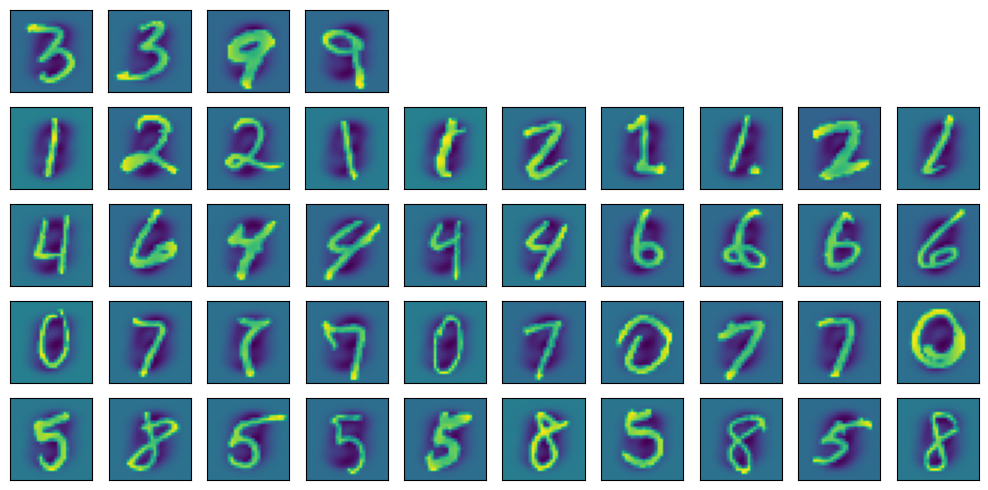

In [53]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

Nx = 10
Nga = round(Ng/2) # this many target samples from one class
Ngb = int(Ng - Nga) # this many target samples from the other class
for cc in range(Nga): # target images
    image_target = Hg1[cc].reshape(28, 28)
    ax = fig.add_subplot(5, 10, cc+1)
    ax.imshow(image_target)
    ax.set_xticks([])
    ax.set_yticks([])
for cc in range(Ngb):
    image_target = Hg2[cc].reshape(28, 28)
    ax = fig.add_subplot(5, 10, cc+1+2)
    ax.imshow(image_target)
    ax.set_xticks([])
    ax.set_yticks([])

Nx = 10
for t in range(T):
    for cc in range(Nx):
        Hx = features_train_database[t]
        image_test = Hx[cc].reshape(28, 28)
        ax = fig.add_subplot(5, 10, (t+1)*Nx+cc+1)
        ax.imshow(image_test)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

plt.savefig("figs/fig-8.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 72.8** The top row shows the four target samples, while the remaining rows show random samples selected from the exploratory datasets $\{{\cal D}_e\}$ for $e=1,2,3,4$.

We train a feedforward neural network with a total of four layers: one input layer, one output layer, and two hidden layers. The size of the input layer is $n_1=784$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_4=2$ (since the network will be discriminating between two classes). The size of hidden layers is set to $n_2=n_3=512$ neurons. We assume the internal nodes employ ReLU activation functions, while the output layer relies on a softmax mapping. During the generation of the exploration models, we train  the network using a regularized cross-entropy criterion with parameters

$
\mu=0.001,\;\;\;\beta=0.001,\;\;\;\rho=0.0001 
$

We run a stochastic-gradient version of the backpropagation algorithm (65.82) with mini-batches of size 1.
We perform $P=2000$ iterations, repeating steps $1$--$8$ in the MAML algorithm (72.107).  We select the initial model $(W^{\star},\theta^{\star})$ at random by setting its parameters according to the construction explained in Section~\ref{sec.inaldlakd.acas} using the Gaussian distributions (65.88)--(65.89).
 
 
At the end of the $P$ runs, we update the resulting launch model to a target model by running 500 epochs of recursion 
(72.84) and randomly reshuffling the target samples at the start of each epoch. We test the performance of the resulting target model $(W^{t,\star},\theta^{t,\star})$ using $1000$ randomly selected handwritten digits $\{3,9\}$ from the MNIST dataset. The simulation led to a $16.4\%$ error rate for the MAML implementation, $14.5\%$ for FOMAML, and  $17.5\%$ for Reptile under the current parameter settings:

$
\textnormal{ MAML target model } (W^{t,\star},\theta^{t,\star}): 16.4\% \\
\textnormal{ FOMAML target model } (W^{t,\star},\theta^{t,\star}) 14.5\% \\
\textnormal{ Reptile target model } (W^{t,\star},\theta^{t,\star}): 17.5\%
$